In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from tqdm import tqdm
import seaborn as sns

In [2]:
G = nx.from_pandas_edgelist(pd.read_csv('data/Gene_Gene.csv'))

In [8]:
path = '../../99_Toolbox/data/Open_Targets_Platform/data/out'
dgs = pd.read_csv(path+'/disease_gene_v2.csv').drop('targets', axis=1).drop_duplicates()
dgs = dgs[dgs.GeneId.notnull()]
dgs = dgs[(~dgs.source.isin(['literature']))]

In [9]:
dgs.source.unique()

array(['genetic_association', 'known_drug', 'somatic_mutation',
       'rna_expression', 'affected_pathway', 'animal_model'], dtype=object)

In [10]:
dgs = dgs[(dgs.source == 'genetic_association') & (dgs.score > 0.1) & (dgs.GeneId.isin(G.nodes()))]

In [11]:
df = dgs.groupby(['efoId', 'efoName'])['GeneId'].size().reset_index(name='Count')
valid_d = df[df.Count > 20].efoId.unique()
dgs = dgs[dgs.efoId.isin(valid_d)]

In [12]:
#disease therapeutic area
ta = dgs[['efoId']].drop_duplicates().merge(
    pd.read_csv(path+'/therapeutic_areas_v2.csv').rename(columns={'efoName':'taName'}), on='efoId', how='left')    

In [13]:
dgs_w_ta = dgs.merge(ta[['efoId', 'taName']], on='efoId', how='left')

In [14]:
dgs_w_ta.taName.nunique(), dgs_w_ta.taName.unique()

(24,
 array(['musculoskeletal or connective tissue disease',
        'hematologic disease', 'genetic, familial or congenital disease',
        'cancer or benign tumor', 'immune system disease',
        'gastrointestinal disease',
        'reproductive system or breast disease', 'infectious disease',
        'urinary system disease',
        'infectious disease or post-infectious disorder',
        'endocrine system disease', 'nutritional or metabolic disease',
        'nervous system disease', 'integumentary system disease',
        'respiratory or thoracic disease', 'cardiovascular disease',
        'psychiatric disorder', 'pancreas disease',
        'disorder of visual system',
        'injury, poisoning or other complication', 'phenotype',
        'measurement', 'biological process',
        'pregnancy or perinatal disease'], dtype=object))

In [15]:
#remove non-disease areas
l = ['injury, poisoning or other complication', 'phenotype', 'measurement', 'biological process']
dgs_w_ta = dgs_w_ta[~dgs_w_ta.taName.isin(l)]

In [16]:
dgs_w_ta.groupby('taName')['GeneId'].apply(set).apply(lambda x: len(x))

taName
cancer or benign tumor                            2292
cardiovascular disease                            2361
disorder of visual system                         1629
endocrine system disease                          2942
gastrointestinal disease                          3048
genetic, familial or congenital disease           5310
hematologic disease                                863
immune system disease                             2388
infectious disease                                 255
infectious disease or post-infectious disorder     255
integumentary system disease                      1694
musculoskeletal or connective tissue disease      2825
nervous system disease                            4510
nutritional or metabolic disease                  2752
pancreas disease                                  1842
pregnancy or perinatal disease                     110
psychiatric disorder                              2749
reproductive system or breast disease             1593
res

In [17]:
dgs_w_ta.efoName.nunique(), dgs_w_ta.taName.nunique()

(388, 20)

array(['atrial fibrillation', 'cardiomyopathy', 'cardiovascular disease',
       'dilated cardiomyopathy', 'hypertension',
       'hypertrophic cardiomyopathy', 'myocardial infarction', 'stroke',
       'systemic scleroderma', 'pulmonary arterial hypertension',
       'coronary artery disease', 'heart failure', 'diabetic retinopathy',
       "behcet's syndrome", 'pulmonary embolism', 'brain aneurysm',
       'atrial flutter', 'abdominal aortic aneurysm',
       'mucocutaneous lymph node syndrome', 'peripheral arterial disease',
       'cardiac arrhythmia', 'sudden cardiac arrest',
       'venous thromboembolism', 'congenital heart disease',
       'ventricular tachycardia', 'large artery stroke',
       'autosomal dominant dilated cardiomyopathy', 'hemorrhoid',
       'myocardial ischemia', 'wolff-parkinson-white syndrome',
       'cardiac edema', 'takayasu arteritis', 'essential hypertension',
       'cor pulmonale', 'vein disorder', 'migraine disorder',
       'varicose disease', 'co

In [18]:
d_genes = dgs_w_ta.groupby('efoName')['GeneId'].apply(set).to_dict()
len(d_genes)

388

In [93]:
#amla chemicals
ct = pd.read_csv('data/chemical_target_experiment.csv')
sel_chem = [k for k,v in ct.chemName.value_counts().to_dict().items() if v >= 10]
ct[ct.chemName.isin(sel_chem)].chemName.value_counts()

Quercetin        66
Ellagic acid     45
Ascorbic acid    29
Kaempferol       16
Citric acid      15
Name: chemName, dtype: int64

In [23]:
for k,v in ct.groupby('chemName')['GeneId'].apply(set).to_dict().items(): d_genes[k] = v 

In [24]:
len(d_genes)

397

In [25]:
#overlap significance
df = []
for i,j in tqdm(combinations(list(d_genes.keys()), 2)):
    A = d_genes[i]
    B = d_genes[j]
    p = hypergeom.sf(len(A&B)-1, G.order(), len(A), len(B))
    df.append([i, j, p])
    df.append([j, i, p])
df = pd.DataFrame(df, columns=['A', 'B', 'p'])
df['p_adj'] =  multipletests(pvals=df.p, method='bonferroni')[1]
df.to_csv('data/target_similarity_mtx.csv', index=False)

78606it [03:24, 384.06it/s] 


In [123]:
#jaccard similarity
df = []
for i,j in tqdm(combinations(list(d_genes.keys()), 2)):
    A = d_genes[i]
    B = d_genes[j]
    js = len(A&B) / len(A|B)
    df.append([i, j, js])
    df.append([j, i, js])
df = pd.DataFrame(df, columns=['A', 'B', 'JS'])
#df.to_csv('data/target_similarity_mtx.csv', index=False)

78606it [00:01, 45562.22it/s]


In [139]:
scol = dict()
cvds = dgs_w_ta[dgs_w_ta.taName == 'cardiovascular disease'].efoName.unique()
#cvds = set(dgs_w_ta['efoName']) & set(similarity_mtx.columns) & others
#for d in cvds: scol[d] = '#43b1c9'
amla = sel_chem
for c in amla: scol[c] = '#43c981'
#others = set(d_genes.keys()) - (set(cvds) | set(amla))
#for k in others: scol[k] = 'black'

In [140]:
similarity_mtx = df[df.JS == 0].pivot(index='A', columns=['B'], values='JS').fillna(1)
#similarity_mtx = df.pivot(index='A', columns=['B'], values='JS').fillna(1)

In [141]:
Qarea = ((set(df[((df.A == 'Quercetin') | (df.B == 'Quercetin')) & (df.JS == 0)]['A']) | set(df[((df.A == 'Quercetin') | (df.B == 'Quercetin')) & (df.JS == 0)]['B'])) & set(dgs_w_ta['efoName']))
for d in Qarea: scol[d] = '#43b1c9'

In [142]:
others = set(d_genes.keys()) - (Qarea | set(amla))
#for k in others: scol[k] = 'black'

KeyError: 'major depressive disorder'

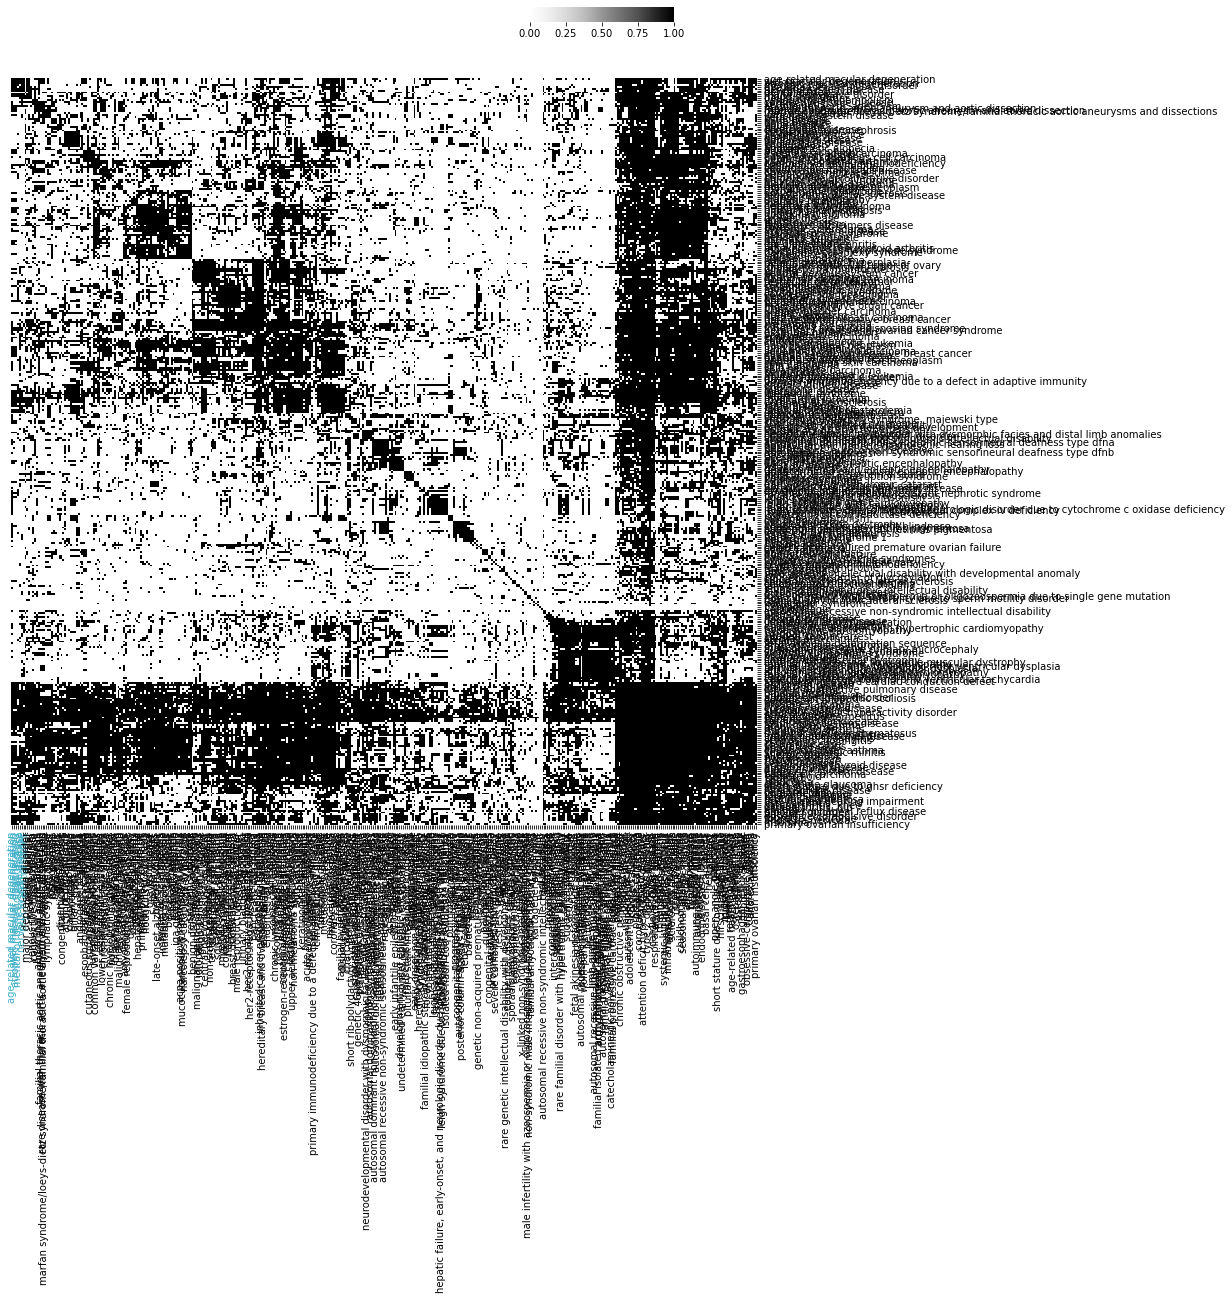

In [143]:
index = others | Qarea | {'Quercetin'}#set(amla)
similarity_mtx_v2 = similarity_mtx.loc[index].copy()
similarity_mtx_v2 = similarity_mtx_v2[list(index)]
#similarity_mtx_v2 = similarity_mtx

g = sns.clustermap(similarity_mtx_v2, cbar_pos=(0.5,.9,.1,.01), figsize=(20,20), cbar_kws={'orientation':'horizontal'}, cmap='Greys', 
    yticklabels=True, xticklabels=True)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

i = 0 
for s in g.ax_heatmap.get_xticklabels():
    g.ax_heatmap.get_xticklabels()[i].set_color(scol[s.get_text()])
    i += 1

i = 0 
for s in g.ax_heatmap.get_yticklabels():
    g.ax_heatmap.get_yticklabels()[i].set_color(scol[s.get_text()])
    i += 1

Negative controls are:
- celiac disease (EFO_0001060), 
- chronic obstructive pulmonary disease (EFO_0000341), 
- multiple sclerosis (MONDO_0005301), 
- rheumatoid arthritis (EFO_0000685), 
- type 1 diabetes mellitus (MONDO_0005147), 
- systemic lupus (EFO_0002690), 
- crohn's disease (EFO_0000384), 
- asthma (MONDO_0004979)
- inflammatory bowel disease (EFO_0003767)
- psoriasis (EFO_0000676)

In [90]:
dgs_w_ta[dgs_w_ta.efoId.isin(['MONDO_0004979', 'EFO_0003767', 'EFO_0000676',])].to_csv('data/amla_non_therapeutic_areas_second_set.csv', index=False)